In [72]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [42]:
fps = 0.2
T_max = 12 #en min
T_max_sec = T_max*60


N = int(T_max_sec/fps) #n_b mesures classes
T = np.linspace(0,T_max,N)


activity_map = {
    'c0': 'Safe driving', 
    'c1': 'Texting - right', 
    'c2': 'Talking on the phone - right', 
    'c3': 'Texting - left', 
    'c4': 'Talking on the phone - left', 
    'c5': 'Operating the radio', 
    'c6': 'Drinking', 
    'c7': 'Reaching behind', 
    'c8': 'Hair and makeup', 
    'c9': 'Talking to passenger'
}

alpha = 10 #Exigence 
score_map = 1/10*alpha*np.array([-2,5,7,5,7,1,3,6,6,5])

Class = np.zeros(N,dtype = int) 
Class[N//4:N//4+100] = 5
Class[N//3:N//2] = 1
Class[N//6:N//5] = 2
Class[N//2+100:N//2+400] = 6

penalite = score_map[Class]

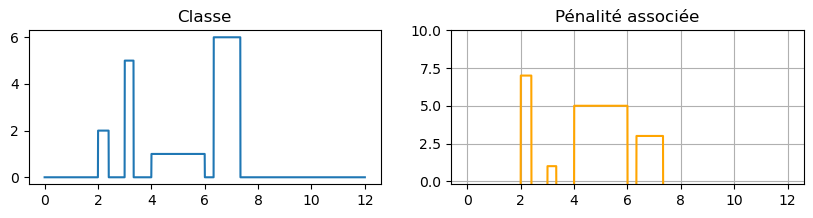

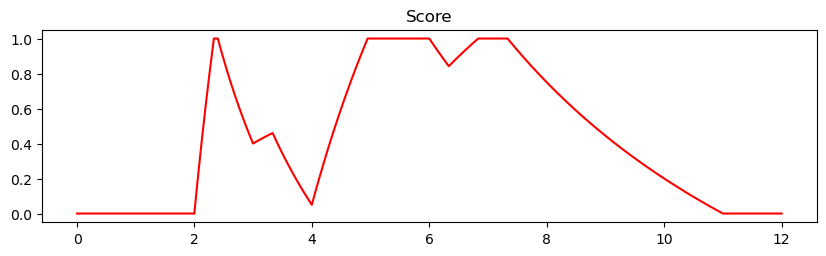

In [43]:
Score = np.zeros(N)
for i in range(1,N):
    Score[i] = max(min((i*Score[i-1]+penalite[i])/(i+1),1),0)

    
plt.figure(figsize = (10,2))
plt.subplot(1,2,1)
plt.plot(T,Class)
plt.title("Classe")
plt.subplot(1,2,2)
plt.ylim(-0.2,10)
plt.grid()
plt.plot(T,penalite,color="orange")
plt.title("Pénalité associée")

plt.figure(figsize = (10,2.5))
plt.title("Score")
plt.plot(T,Score,color="red")

In [ ]:
# 1. Naturellement entre 0,1
# 2. Prend en compte la durée de distraction
# 3. Prend en compte le type de distraction (chaque distraction n'a pas le même poids)
# 4. Un 1-le score d'avant 
# 5. Fenêtre ou en continue ? Mémoire ?
# Définition d'un trajet :
"""
Trajet (array-like)
[
[T0,D0],
[T1,D1],
(...)
[Tn,Dn]
]

avec :
 Ti (float) : valeur du temps relevé
 Di(int)    : distraction détectée (0->9)
"""

In [16]:
T= np.array([[0,0],[5,3],[18,0]])
T

array([[ 0,  0],
       [ 5,  3],
       [18,  0]])

In [14]:
temps = np.diff(T,axis=0)
temps

array([[ 5,  3],
       [13, -3]])

In [93]:
activity_map = {
    0: 'Safe driving',
    1: 'Texting - right',
    2: 'Talking on the phone - right',
    3: 'Texting - left',
    4: 'Talking on the phone - left',
    5: 'Operating the radio',
    6: 'Drinking',
    7: 'Reaching behind',
    8: 'Hair and makeup',
    9: 'Talking to passenger'
}
def associate_id_to_distraction(input_data):
    """
    Args:
        input_data (array-like) or (int): indices des distractions considérées
    Returns: (array de string) ou (string) des distractions
    Raise : Type error si input_data n'est pas de type array ou int
    """
    if type(input_data)==int:
        return activity_map[id]
    else :
        N=len(input_data)
        result = [0 for _ in range(N)]
        for i in range(N):
            result[i]=activity_map[input_data[i]]
        return result

In [79]:
def compute_score(time,id_distraction,alpha=0.1,beta=0.01,weights = None ):
    assert time>0 , f"le temps donnée doit être positif  : {time}"
    assert id_distraction>=0.0 and id_distraction<=9.0 , f"Le type de distraction doit être un entier entre 0 et 9 : {id_distraction}"
    if weights is None:
        weights = [-2,5,7,5,7,1,3,6,6,5]
    if id_distraction==0:
        return - np.exp(+beta*time)
    else:
        return + weights[id_distraction] * np.exp(+alpha*time)

In [95]:
def compute_score_trajet(trajet,is_displayed=False,weights = None,alpha=0.1,beta=0.01):
    """
    Args:
        trajet (np-array): tableau contenant les tuples (temps (float),id_distraction (int)) du trajet dans l'odre croissant de temps
                            tel que trajet.shape = (E,2)
                            E est le nombre de changement d'état lors du trajet (distrait -> normal -> distrait donne deux changements)
        is_displayed (Boolean): indique si l'évolution du score est affichée
        weights(array-like) : poids utilisés pour chaque distraction (len(weights=9))
        alpha (float): paramètre sur l'influence du temps lors d'une pénalité sur le score
        beta (float): paramètre sur l'influence du temps lors d'un bonus sur le score

    Returns: tuple (np-array,np-array)  : (score,times) contenant les scores calculés et les temps de distraction correspondants
    """
    if type(trajet)!=np.ndarray:
        trajet=np.array(trajet)
    assert type(trajet)== np.ndarray , f"Le trajet n'est pas un array numpy, type : {type(trajet)}"

    N = len(trajet)
    assert N>3 , f"Trajet trop court, taille N = {N}"

    #Definition des sorties :
    score = [0 for _ in range(N-1)]
    times = [0 for _ in range(N-1)]

    #Score initial :
    score[0]=max(compute_score(time=trajet[1][0]-trajet[0][0],id_distraction=int(trajet[0][1]),weights=weights,alpha=alpha,beta=beta),0)
    times[0]=trajet[1][0]-trajet[0][0]
    for ind_detection in range(1,N-1):
        time_lapse = trajet[ind_detection+1][0]-trajet[ind_detection][0] # temps passé dans la distraction courante

        score[ind_detection] = max(score[ind_detection-1]+compute_score(time = time_lapse ,id_distraction=int(trajet[ind_detection][1]),weights=weights,alpha=alpha,beta=beta),0)
        times[ind_detection]= time_lapse


        df = {'time': trajet[0:-1,0], 'score': score , 'distraction' : associate_id_to_distraction(trajet[0:-1,1])}
        fig = px.line(df, x="time", y="score", text="distraction")
        fig.update_traces(textposition="bottom right")
        fig.show()
    return np.array(score),np.array(times)

In [96]:
trajet_test_1 = np.array([
    [0,0],
    [2.36,1],
    [6.9,6],
    [10.0,9],
    [15.3,0],
    [19.3,5],
    [20.0,0],
    [25.2,3]
])

In [98]:
_,_ = compute_score_trajet(trajet=trajet_test_1,is_displayed=True)